In [159]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from sklearn import preprocessing
import importlib
importlib.reload(fs)

<module 'feature_selection' from 'C:\\Users\\faisal\\PycharmProjects\\linkPrediction\\feature_selection.py'>

In [2]:
filepath=['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv']
graphpath='C:/Users/faisal/PycharmProjects/linkPrediction/graphs'
ts=1990
te=2001
it_index=5
df, key_list = ut.load_dataset(filepath)

In [53]:
nodes={}
#dynamic graph build and save
for t in range(ts,te,it_index):
    t0=t
    t1=t0+4
    t2=t1+1
    nodes[t1]=gr.nodes_intersection(df, key_list, t0, t1, t2)
    #train graph buile and save
    for t_in in range(t0,t1):
        g=nx.Graph()
        train_graph = gr.build_graph(g, df, key_list, nodes[t1], t_in, t_in+1)
        file="train_graph_"+str(t_in)
        file_name = os.path.join(graphpath, file+".gpickle")
        gr.save_graph(train_graph, file_name)
        print(file_name+" saved,","nodes:",len(train_graph.nodes()),"edges:",len(train_graph.edges()))
    #test graph build and save
    g=nx.Graph()
    test_graph = gr.build_graph(g, df, key_list, nodes[t1], t1, t2)
    file="test_graph_"+str(t1)
    file_name = os.path.join(graphpath, file+".gpickle")
    gr.save_graph(test_graph, file_name)
    print(file_name+" saved,","nodes:",len(test_graph.nodes()),"edges:",len(test_graph.edges()))

1990
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1990.gpickle saved, nodes: 30 edges: 10
1991
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1991.gpickle saved, nodes: 46 edges: 36
1992
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1992.gpickle saved, nodes: 44 edges: 27
1993
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1993.gpickle saved, nodes: 47 edges: 26
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\test_graph_1994.gpickle saved, nodes: 93 edges: 83
1995
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1995.gpickle saved, nodes: 115 edges: 147
1996
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1996.gpickle saved, nodes: 122 edges: 149
1997
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1997.gpickle saved, nodes: 133 edges: 129
1998
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1998.gpickle saved, nodes: 136 edges: 145

In [86]:
#static graph build and save
for t in range(ts,te,it_index):
    t0=t
    t1=t0+4
    t2=t1+1
    #train graph buile and save
    g=nx.Graph()
    train_graph = gr.build_graph(g, df, key_list, nodes[t1], t0, t1)
    file="train_graph_"+str(t0)+"-"+str(t1)
    file_name = os.path.join(graphpath, file+".gpickle")
    gr.save_graph(train_graph, file_name)
    print(file_name+" saved,","nodes:",len(train_graph.nodes()),"edges:",len(train_graph.edges()))

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1990-1994.gpickle saved, nodes: 93 edges: 86
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1995-1999.gpickle saved, nodes: 249 edges: 467
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2000-2004.gpickle saved, nodes: 390 edges: 952


In [3]:
#load graph
g_train={}
g_test={}
for t in range(ts,te,it_index):
    t0=t
    t1=t0+4
    t2=t1+1
    for t_in in range(t0,t1):
        file="train_graph_"+str(t_in)
        file_name = os.path.join(graphpath, file+".gpickle")
        g_train[t_in]=gr.load_graph(file_name)
        print(file_name+" loaded,","nodes:",len(g_train[t_in].nodes()),"edges:",len(g_train[t_in].edges()))
    file="test_graph_"+str(t1)
    file_name = os.path.join(graphpath, file+".gpickle")
    g_test[t1]=gr.load_graph(file_name)
    print(file_name+" loaded,","nodes:",len(g_test[t1].nodes()),"edges:",len(g_test[t1].edges()))

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1990.gpickle loaded, nodes: 30 edges: 10
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1991.gpickle loaded, nodes: 46 edges: 36
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1992.gpickle loaded, nodes: 44 edges: 27
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1993.gpickle loaded, nodes: 47 edges: 26
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\test_graph_1994.gpickle loaded, nodes: 93 edges: 83
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1995.gpickle loaded, nodes: 115 edges: 147
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1996.gpickle loaded, nodes: 122 edges: 149
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1997.gpickle loaded, nodes: 133 edges: 129
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1998.gpickle loaded, nodes: 136 edges: 145
C:/Users/faisal/PycharmProject

In [4]:
#build dataset for feature
train_data={}
test_data={}
for t in range(ts,te,it_index):
    t0=t
    t1=t0+4
    t2=t1+1
    for t_in in range(t0,t1):
        train_data[t_in] = cl.classification_train_data(g_train[t_in],g_test[t1])
        cl.print_attributes(train_data[t_in],'train')
    test_data[t1] = cl.classification_test_data(g_test[t1])
    cl.print_attributes(test_data[t1],'test')

positive train: 17 negative train: 408 train_size: 425
positive train: 24 negative train: 975 train_size: 999
positive train: 27 negative train: 892 train_size: 919
positive train: 34 negative train: 1021 train_size: 1055
test_size: 83
positive train: 66 negative train: 6342 train_size: 6408
positive train: 79 negative train: 7153 train_size: 7232
positive train: 104 negative train: 8545 train_size: 8649
positive train: 89 negative train: 8946 train_size: 9035
test_size: 265
positive train: 210 negative train: 15428 train_size: 15638
positive train: 204 negative train: 19999 train_size: 20203
positive train: 197 negative train: 19415 train_size: 19612
positive train: 252 negative train: 26464 train_size: 26716
test_size: 584


In [5]:
#load static graph and build static train dataset
g_train_static={}
static_train={}
for t in range(ts,te,it_index):
    t0=t
    t1=t0+4
    t2=t1+1
    file="train_graph_"+str(t0)+"-"+str(t1)
    file_name = os.path.join(graphpath, file+".gpickle")
    g_train_static[t0]=gr.load_graph(file_name)
    print(file_name+" loaded,","nodes:",len(g_train_static[t0].nodes()),"edges:",len(g_train_static[t0].edges()))
    static_train[t0] = cl.classification_train_data(g_train_static[t0],g_test[t1])
    cl.print_attributes(static_train[t0],'train')

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1990-1994.gpickle loaded, nodes: 93 edges: 86
positive train: 65 negative train: 4127 train_size: 4192
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1995-1999.gpickle loaded, nodes: 249 edges: 467
positive train: 184 negative train: 30225 train_size: 30409
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2000-2004.gpickle loaded, nodes: 390 edges: 952
positive train: 372 negative train: 74531 train_size: 74903


In [17]:
#calculate static node features
ts=1990
te=2001
it_index=5
static_node_feature={}
article_feature={}
for t in range(ts,te,it_index):
    t0=t
    t1=t0+4
    t2=t1+1
    static_node_feature[t0],article_feature[t0] = fs.build_feature_set(df, key_list, g_train_static[t0], t0, t1)
#     static_node_feature[t0]['y_weight']=0
#     for i in g_train_static[t0].nodes(data=True):
#         static_node_feature[t0].loc[static_node_feature[t0]['node_index']==i[0],['y_weight']]=len(i[1]['year'])

290
832
1369


In [134]:
#insert node feature multiplication into edge data: experimental
ts=1990
te=2001
it_index=5
for t in range(ts,te,it_index):
    t0=t
    t1=t0+4
    t2=t1+1
    static_train[t0]['y_weight']=0
    static_train[t0]['tc']=0
    
    y_weight_dict = dict(zip(static_node_feature[t0].node_index,static_node_feature[t0].y_weight))
    tc_dict = dict(zip(static_node_feature[t0].node_index,static_node_feature[t0].term_centrality))
    
    static_train[t0]['y_weight'] = static_train[t0].apply(lambda row: y_weight_dict[row['row_name'][0]]
                                                          *y_weight_dict[row['row_name'][1]], axis=1)

    static_train[t0]['tc'] = static_train[t0].apply(lambda row: tc_dict[row['row_name'][0]]+tc_dict[row['row_name'][1]], axis=1)


In [136]:
#pruned train data
pr_train = static_train[1990][(((static_train[1990]['y_weight']>4) & (static_train[1990]['label']==0))|
                               ((static_train[1990]['y_weight']>0) & (static_train[1990]['label']==1)))]
print(len(pr_train[(pr_train['label']==1)]),len(pr_train[(pr_train['label']==0)]))

65 589


In [6]:
cm_neigh_len=[]
cm_neigh_list=[]
for i,j in train_data[1993].iterrows():
    coun=0
    cm = list(nx.common_neighbors(g_train[1993], j[0][0],j[0][1]))
    cm_neigh_len.append(len(cm))
    cm_neigh_list.append(cm)
train_data[1993]['cm']=cm_neigh_len
pref = nx.preferential_attachment(g_train[1993],list(train_data[1993]['row_name']))
pref = list(pref)
train_data[1993]['pref']=np.array(pref)[:,2]

In [7]:
l1=len(train_data[1993][((train_data[1993]['pref']>0) & (train_data[1993]['label']==0))])
l2=len(train_data[1993][((train_data[1993]['pref']>0) & (train_data[1993]['label']==1))])
print(l1,l2)

426 13


In [147]:
#title analysis
for i,j in train_data[1991].iterrows():
    node1=gr.node_label_find(key_list,j[0][0])
    node2=gr.node_label_find(key_list,j[0][1])
#     if (j[1]==0):
#         print(node1,'+',node2,"------------------")
#         print(g_train[1991].nodes[j[0][0]]['title'])
#         print('--------------------')
#         print(g_train[1991].nodes[j[0][1]]['title'])
#         print('\n')

In [156]:
posset={}
negset={}
for i in range(1990,1994):
    posset[i] = (set(train_data[i][(train_data[i]['label']==1)]['row_name']))
    negset[i] = (set(train_data[i][(train_data[i]['label']==0)]['row_name']))
static_pos = set(static_train[1990][(static_train[1990]['label']==1)]['row_name'])
static_neg = set(static_train[1990][(static_train[1990]['label']==0)]['row_name'])

In [132]:
jj=4
coun=0
total=0
for i,j in pr_train.iterrows():
        paths = list( nx.all_simple_paths(g_train_static[1990], source=j[0][0], target=j[0][1],cutoff=jj))
        if j['label']==0:
            if len(paths)!=0:
                coun=coun+1
            total=total+1
print(coun,total)            

129 199


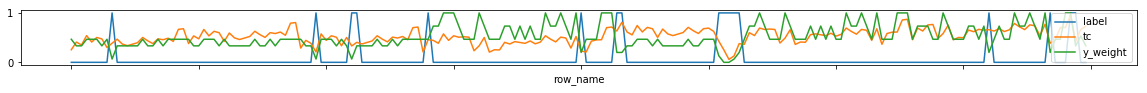

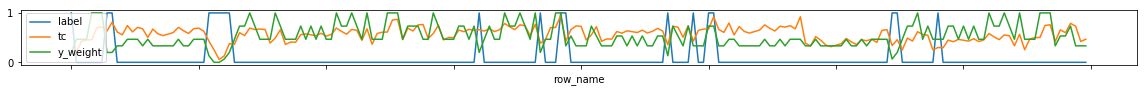

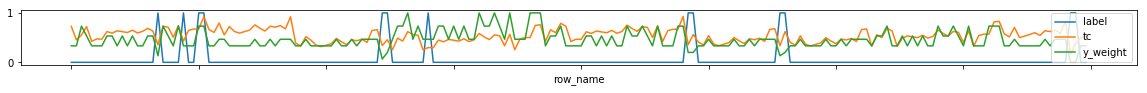

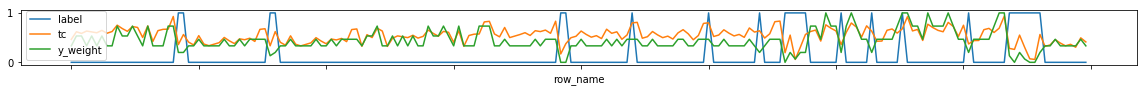

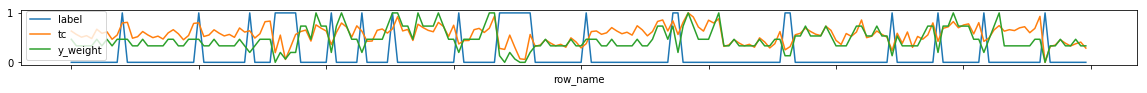

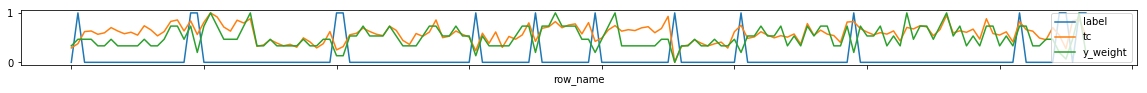

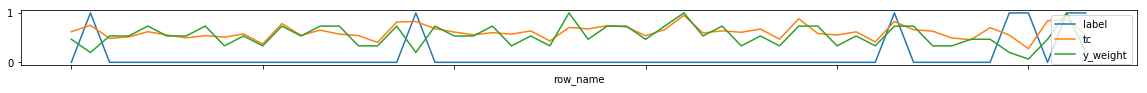

In [230]:
pr_train
for i in range(0,654,100):
    pr_train[i:i+200].plot(x="row_name", y=["label", "tc","y_weight"],figsize=(20, 1))
    plt.show()

In [231]:
pr_train

,row_name,label,y_weight,tc,y_weight0,y_weight1
3,"(14850, 9240)",0,0.466667,0.254524,2,4
8,"(14850, 6950)",0,0.333333,0.409658,2,3
9,"(14850, 1832)",0,0.333333,0.350926,2,3
14,"(14850, 6451)",0,0.466667,0.540381,2,4
16,"(14850, 6200)",0,0.466667,0.410530,2,4
17,"(14850, 6713)",0,0.466667,0.503023,2,4
18,"(14850, 6716)",0,0.333333,0.473392,2,3
29,"(14850, 13395)",0,0.466667,0.299828,2,4
30,"(14850, 10323)",1,0.066667,0.386275,2,1
32,"(14850, 2656)",0,0.333333,0.468396,2,3


In [211]:
pr_train['y_weight']=(pr_train['y_weight']-pr_train['y_weight'].min())/(pr_train['y_weight'].max()-pr_train['y_weight'].min())
pr_train['tc']=(pr_train['tc']-pr_train['tc'].min())/(pr_train['tc'].max()-pr_train['tc'].min())

C:\Users\faisal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\faisal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
